# Hindi dataset

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [3]:
emotion_hindi_df = pd.read_csv('/content/Emotion_attached_final_hindi.csv')
emotion_hindi_df.head()

,Text_description,emotion_label
0,परधनमतर नरदर मद अमरक रषटरपत ज बइडन क बच पछल दन...,positive
1,मर पत चहत थ क म हमश तयर सज सवर रह म मथ बड बद ल...,positive
2,गजरत म लगतर ह रह भर बरश क करण जल म बढ क सथत बन...,positive
3,अवन लखर परस परलपक म महलओ क मटर एयर रइफल सटडग स...,anger
4,परस परलपक खल क शरआत अगसत स ह चक ह ओपनग सरमन म ...,negative


In [4]:
emotion_hindi_df.shape

(12037, 2)

In [5]:
emotion_hindi_df.isnull().sum()

,0
Text_description,0
emotion_label,0


In [6]:
texts = emotion_hindi_df['Text_description'].astype(str)
labels = emotion_hindi_df['emotion_label']

In [7]:
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_classes = len(le.classes_)
print("Classes:", le.classes_, "| Num classes:", num_classes)

Classes: ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'negative' 'neutral'
 'positive' 'sadness' 'surprise' 'trust'] | Num classes: 11


In [8]:
# 3. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels_enc,
    test_size=0.2,
    random_state=42,
    stratify=labels_enc
)

In [9]:
# 4. Tokenize & pad
max_words = 10000
max_len   = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

In [10]:
# 5. Prepare labels for sparse loss
y_train = y_train.reshape(-1).astype('int32')
y_test  = y_test.reshape(-1).astype('int32')

In [11]:
# 6. Build the CNN model (with explicit input shape)
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_shape=(max_len,)),      # ← triggers shape inference
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# 7. Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
# 8. Inspect summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,073,099 (4.09 MB)

 Trainable params: 1,073,099 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 9. Train with EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[es]
)

Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.2845 - loss: 2.0198 - val_accuracy: 0.5254 - val_loss: 1.4290
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5491 - loss: 1.4690 - val_accuracy: 0.6251 - val_loss: 1.1833
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6305 - loss: 1.2139 - val_accuracy: 0.6573 - val_loss: 1.0465
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6826 - loss: 1.0264 - val_accuracy: 0.6636 - val_loss: 1.0060
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7328 - loss: 0.8932 - val_accuracy: 0.6926 - val_loss: 0.9773
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7880 - loss: 0.7311 - val_accuracy: 0.6999 - val_loss: 0.9979
Epoch 7/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8097 - loss: 0.6492 - val_accuracy: 0.6968 - val_loss: 1.0444
Epoch 8/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8307 - loss: 0.5538 - val_accuracy: 

In [15]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6871 - loss: 1.0266
Test Accuracy: 0.6977


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


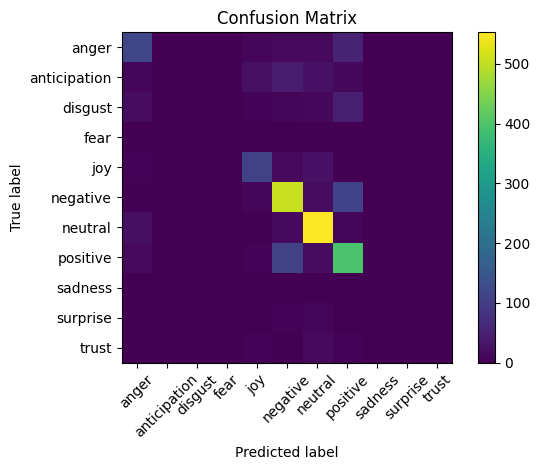

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Get model predictions (assuming model, X_test_pad, and y_test exist)
y_pred_prob = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# 2. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# 3. Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(np.arange(len(le.classes_)), le.classes_)
plt.colorbar()
plt.tight_layout()
plt.show()


# Telugu Dataset


In [17]:
emotion_telugu_df = pd.read_csv('/content/Emotion_attached_final_telugu.csv')
emotion_telugu_df.head()

,cleaned_text,emotion_label
0,ట్రంప్‌ సుంకాల నేపథ్యంలో ఆర్థికమంత్రి నిర్మలా ...,neutral
1,"భారత మార్కెట్లు ట్రంప్‌ సుంకాల విరామం, వాణిజ్య...",neutral
2,ఎన్‌ఎస్ఈ ఐపీఓ అనుమతిలో వాణిజ్య ప్రయోజనాల కంటే ...,neutral
3,ఐటీసీ గ్రూప్‌ 24 మంత్ర ఆర్గానిక్‌ బ్రాండ్‌ను ర...,neutral
4,టాటా మోటార్స్‌ 2024-25 ఆర్థిక సంవత్సరంలో 250 ప...,neutral


In [18]:
emotion_telugu_df.shape

(10628, 2)

In [19]:
emotion_telugu_df.isnull().sum()

,0
cleaned_text,0
emotion_label,0


In [20]:
texts = emotion_telugu_df['cleaned_text'].astype(str)
labels = emotion_telugu_df['emotion_label']

In [21]:
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_classes = len(le.classes_)
print("Classes:", le.classes_, "| Num classes:", num_classes)

Classes: ['anger' 'anticipation' 'disgust' 'fear' 'negative' 'neutral' 'positive'
 'trust'] | Num classes: 8


In [22]:
# 3. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels_enc,
    test_size=0.2,
    random_state=42,
    stratify=labels_enc
)

In [23]:
# 4. Tokenize & pad
max_words = 10000
max_len   = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

In [24]:
# 5. Prepare labels for sparse loss
y_train = y_train.reshape(-1).astype('int32')
y_test  = y_test.reshape(-1).astype('int32')

In [25]:
# 6. Build the CNN model (with explicit input shape)
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_shape=(max_len,)),      # ← triggers shape inference
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# 7. Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [27]:
# 8. Inspect summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,904 (4.09 MB)

 Trainable params: 1,072,904 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# 9. Train with EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[es]
)

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6722 - loss: 1.2266 - val_accuracy: 0.7591 - val_loss: 0.7717
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7705 - loss: 0.7610 - val_accuracy: 0.8108 - val_loss: 0.5982
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8504 - loss: 0.5451 - val_accuracy: 0.8284 - val_loss: 0.5394
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8762 - loss: 0.4156 - val_accuracy: 0.8261 - val_loss: 0.5425
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8944 - loss: 0.3386 - val_accuracy: 0.8425 - val_loss: 0.5968
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9109 - loss: 0.2842 - val_accuracy: 0.8355 - val_loss: 0.6166


In [29]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8216 - loss: 0.5642
Test Accuracy: 0.8311


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


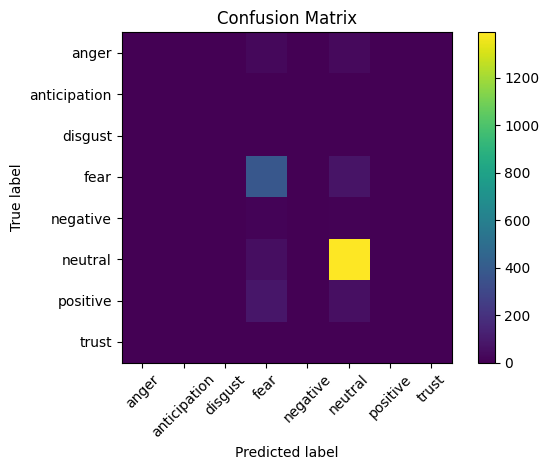

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Get model predictions (assuming model, X_test_pad, and y_test exist)
y_pred_prob = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# 2. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# 3. Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(np.arange(len(le.classes_)), le.classes_)
plt.colorbar()
plt.tight_layout()
plt.show()

In [31]:
# Both CNN And LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


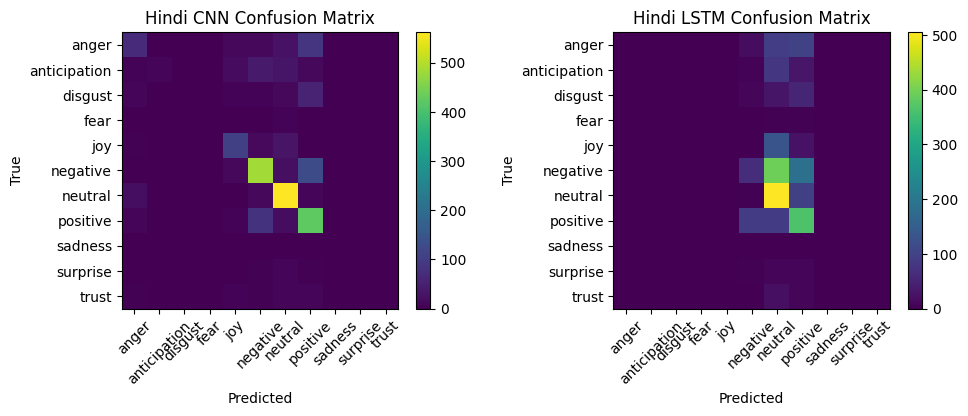

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


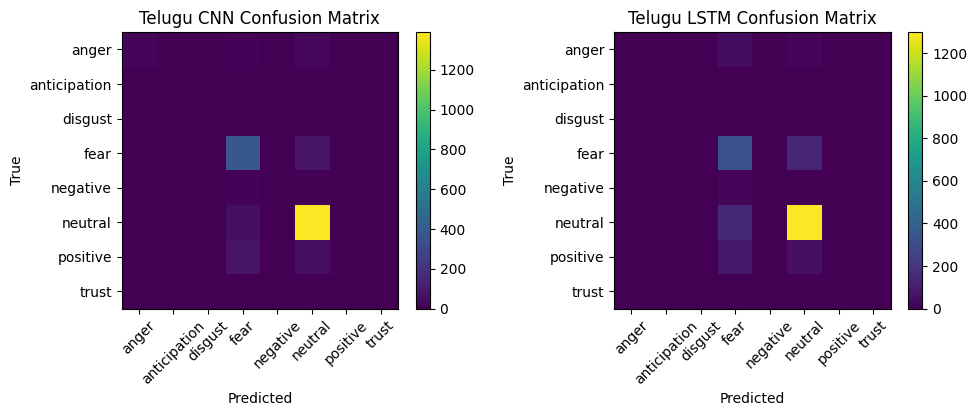

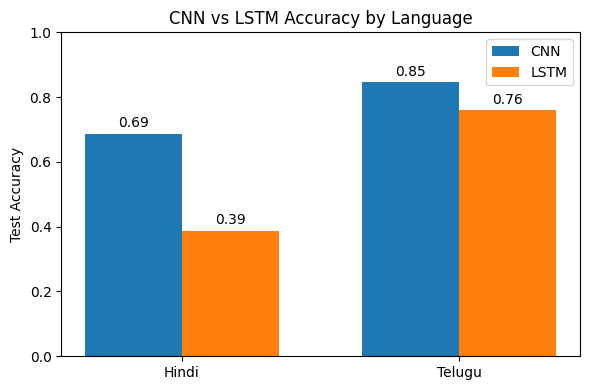

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Configuration for both languages
datasets = [
    ('Hindi', '/content/Emotion_attached_final_hindi.csv', 'Text_description'),
    ('Telugu', '/content/Emotion_attached_final_telugu.csv', 'cleaned_text'),
]

max_words = 10000
max_len = 100
embedding_dim = 100
batch_size = 64
epochs = 10

# Store results for comparison
results = {}

for lang, path, text_col in datasets:
    # 1. Load and preprocess
    df = pd.read_csv(path)
    texts = df[text_col].astype(str)
    labels = df['emotion_label']

    le = LabelEncoder()
    labels_enc = le.fit_transform(labels)
    num_classes = len(le.classes_)

    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels_enc,
        test_size=0.2,
        random_state=42,
        stratify=labels_enc
    )

    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    X_train_pad = pad_sequences(
        tokenizer.texts_to_sequences(X_train),
        maxlen=max_len, padding='post', truncating='post'
    )
    X_test_pad = pad_sequences(
        tokenizer.texts_to_sequences(X_test),
        maxlen=max_len, padding='post', truncating='post'
    )

    y_train = y_train.reshape(-1).astype('int32')
    y_test = y_test.reshape(-1).astype('int32')

    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # 2. Build & train CNN
    cnn = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(max_len,)),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),
    ])
    cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    cnn.fit(X_train_pad, y_train, validation_split=0.1, epochs=epochs,
            batch_size=batch_size, callbacks=[es], verbose=0)
    loss_cnn, acc_cnn = cnn.evaluate(X_test_pad, y_test, verbose=0)
    y_pred_cnn = np.argmax(cnn.predict(X_test_pad), axis=1)
    cm_cnn = confusion_matrix(y_test, y_pred_cnn)

    # 3. Build & train LSTM
    lstm = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(max_len,)),
        LSTM(128),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),
    ])
    lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    lstm.fit(X_train_pad, y_train, validation_split=0.1, epochs=epochs,
             batch_size=batch_size, callbacks=[es], verbose=0)
    loss_lstm, acc_lstm = lstm.evaluate(X_test_pad, y_test, verbose=0)
    y_pred_lstm = np.argmax(lstm.predict(X_test_pad), axis=1)
    cm_lstm = confusion_matrix(y_test, y_pred_lstm)

    # Save results
    results[lang] = {
        'label_encoder': le,
        'accuracy': {'CNN': acc_cnn, 'LSTM': acc_lstm},
        'confusion_matrices': {'CNN': cm_cnn, 'LSTM': cm_lstm}
    }

    # 4. Plot confusion matrices for this language
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    for ax, cm, title in zip(
        axes,
        [cm_cnn, cm_lstm],
        [f'{lang} CNN Confusion Matrix', f'{lang} LSTM Confusion Matrix']
    ):
        im = ax.imshow(cm, interpolation='nearest')
        ax.set_title(title)
        ax.set_xticks(np.arange(num_classes))
        ax.set_xticklabels(le.classes_, rotation=45)
        ax.set_yticks(np.arange(num_classes))
        ax.set_yticklabels(le.classes_)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# 5. Compare accuracies across languages
fig, ax = plt.subplots(figsize=(6,4))
labels = list(results.keys())
cnn_acc = [results[l]['accuracy']['CNN'] for l in labels]
lstm_acc = [results[l]['accuracy']['LSTM'] for l in labels]

x = np.arange(len(labels))
width = 0.35

ax.bar(x - width/2, cnn_acc, width, label='CNN')
ax.bar(x + width/2, lstm_acc, width, label='LSTM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Test Accuracy')
ax.set_title('CNN vs LSTM Accuracy by Language')
ax.legend()
for i in range(len(labels)):
    ax.text(x[i] - width/2, cnn_acc[i] + 0.02, f"{cnn_acc[i]:.2f}", ha='center')
    ax.text(x[i] + width/2, lstm_acc[i] + 0.02, f"{lstm_acc[i]:.2f}", ha='center')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [33]:
accuracy_df = pd.DataFrame([
    {
        'Language': lang,
        'CNN Accuracy': results[lang]['accuracy']['CNN'],
        'LSTM Accuracy': results[lang]['accuracy']['LSTM']
    }
    for lang in results
])

In [34]:
accuracy_df

,Language,CNN Accuracy,LSTM Accuracy
0,Hindi,0.686462,0.387874
1,Telugu,0.845249,0.760113


# HINDI MBERT

In [35]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [36]:
pip install tensorflow tensorflow-text tensorflow-hub


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score # Import accuracy_score
# Import necessary classes from transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict # Import DatasetDict
import torch


df = pd.read_csv('/content/Emotion_attached_final_hindi.csv')
texts = df['Text_description'].astype(str).tolist()
labels = df['emotion_label'].tolist()

# Encode labels
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_labels = len(le.classes_)

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels_enc, test_size=0.2, stratify=labels_enc, random_state=42
)

# Tokenizer & model
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=num_labels)

# Prepare dataset using DatasetDict
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=128)

train_dataset = Dataset.from_dict({
    **train_encodings,
    'labels': train_labels,
})
test_dataset = Dataset.from_dict({
    **test_encodings,
    'labels': test_labels,
})

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
})
# Training arguments
training_args = TrainingArguments(
    output_dir='./mbert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./mbert_logs',
    logging_steps=50,
    save_total_limit=1
)

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, preds)}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'], # Use the 'train' split from the dataset
    eval_dataset=dataset['test'],   # Use the 'test' split from the dataset
    compute_metrics=compute_metrics
)

# Train & evaluate
trainer.train()
metrics = trainer.evaluate()
print("mBERT Test Accuracy:", metrics['eval_accuracy'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nayudammacnarne (nayudammacnarne-california-state-university-east-bay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,1.874500
100,1.780900
150,1.707200
200,1.649700
250,1.747500
300,1.739600
350,1.719800
400,1.691200
450,1.673300
500,1.761000


mBERT Test Accuracy: 0.6794019933554817


In [43]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# 1. Load & encode
df = pd.read_csv('/content/Emotion_attached_final_hindi.csv')
texts = df['Text_description'].astype(str).tolist()
labels = df['emotion_label'].tolist()

le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_labels = len(le.classes_)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels_enc, test_size=0.2, stratify=labels_enc, random_state=42
)

# 2. Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.enc = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

# 3. Tokenizer & model
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model     = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased', num_labels=num_labels
)

train_ds = SentimentDataset(train_texts, train_labels, tokenizer)
test_ds  = SentimentDataset(test_texts,  test_labels,  tokenizer)

# 4. TrainingArguments
training_args = TrainingArguments(
    output_dir='./mbert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./mbert_logs',
    logging_steps=50,
    save_total_limit=1
)

# 5. Trainer & metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

# 6. Train & eval
trainer.train()
res = trainer.evaluate()
print("mBERT Test Accuracy:", res['eval_accuracy'])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.796000
100,1.556900
150,1.357700
200,1.263500
250,1.395400
300,1.379200
350,1.298100
400,1.272300
450,1.208800
500,1.256600


mBERT Test Accuracy: 0.7524916943521595


# mBERT TELUGU


In [46]:
# 1. Load & encode
df = pd.read_csv('/content/Emotion_attached_final_telugu.csv')
texts = df['cleaned_text'].astype(str).tolist() # Changed 'Text_description' to 'cleaned_text'
labels = df['emotion_label'].tolist()

In [48]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# 1. Load & encode
df = pd.read_csv('/content/Emotion_attached_final_telugu.csv')
texts = df['cleaned_text'].astype(str).tolist() # Changed 'Text_description' to 'cleaned_text'
labels = df['emotion_label'].tolist()

le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_labels = len(le.classes_)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels_enc, test_size=0.2, stratify=labels_enc, random_state=42
)

# 2. Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.enc = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

# 3. Tokenizer & model
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model     = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased', num_labels=num_labels
)

train_ds = SentimentDataset(train_texts, train_labels, tokenizer)
test_ds  = SentimentDataset(test_texts,  test_labels,  tokenizer)

# 4. TrainingArguments
training_args = TrainingArguments(
    output_dir='./mbert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./mbert_logs',
    logging_steps=50,
    save_total_limit=1
)

# 5. Trainer & metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

# 6. Train & eval
trainer.train()
res = trainer.evaluate()
print("mBERT Test Accuracy:", res['eval_accuracy'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.963500
100,0.860700
150,0.830900
200,0.757400
250,0.772000
300,0.803700
350,0.780300
400,0.756300
450,0.783100
500,0.722300


mBERT Test Accuracy: 0.8005644402634055


# INDIC BERT


In [40]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers


Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 6.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124


In [51]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# 1. Load & encode (swap path/column for Telugu)
df = pd.read_csv('/content/Emotion_attached_final_hindi.csv')
texts = df['Text_description'].astype(str).tolist()
labels = df['emotion_label'].tolist()

le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_labels = len(le.classes_)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels_enc, test_size=0.2, stratify=labels_enc, random_state=42
)

# 2. Dataset class (same as above)
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.enc = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

# 3. Tokenizer & model
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model     = AutoModelForSequenceClassification.from_pretrained(
    'ai4bharat/indic-bert', num_labels=num_labels
)

train_ds = SentimentDataset(train_texts, train_labels, tokenizer)
test_ds  = SentimentDataset(test_texts,  test_labels,  tokenizer)

# 4. TrainingArguments
training_args = TrainingArguments(
    output_dir='./indicbert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./indicbert_logs',
    logging_steps=50,
    save_total_limit=1
)

# 5. Trainer & metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

# 6. Train & eval
trainer.train()
res = trainer.evaluate()
print("IndicBERT Test Accuracy:", res['eval_accuracy'])


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Step,Training Loss
50,1.938300
100,1.746800
150,1.699400
200,1.606500
250,1.592400
300,1.571100
350,1.510300
400,1.449200
450,1.421100
500,1.472200


IndicBERT Test Accuracy: 0.6482558139534884


In [52]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# 1. Load & encode your data
df = pd.read_csv('/content/Emotion_attached_final_hindi.csv')
texts = df['Text_description'].astype(str).tolist()
labels = df['emotion_label'].tolist()

# ─ Encode labels ─
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_labels = len(le.classes_)

# ─ Train/test split ─
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels_enc,
    test_size=0.2,
    stratify=labels_enc,
    random_state=42
)

# 2. PyTorch Dataset for HF Trainer
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.enc = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=max_len
        )
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# 3. Initialize tokenizer & model
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model     = AutoModelForSequenceClassification.from_pretrained(
    'ai4bharat/indic-bert',
    num_labels=num_labels
)

# 4. Create HF datasets
train_ds = SentimentDataset(train_texts, train_labels, tokenizer)
test_ds  = SentimentDataset(test_texts,  test_labels,  tokenizer)

# 5. TrainingArguments
training_args = TrainingArguments(
    output_dir='./indicbert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./indicbert_logs',
    logging_steps=50,
    save_total_limit=1
)

# 6. Trainer & metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

# 7. Train & evaluate
trainer.train()
res = trainer.evaluate()
print("IndicBERT Test Accuracy:", res['eval_accuracy'])


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.977900
100,1.764700
150,1.691400
200,1.602600
250,1.547200
300,1.562100
350,1.507800
400,1.473500
450,1.442000
500,1.515600


IndicBERT Test Accuracy: 0.6470099667774086


In [54]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# 1. Load & encode your data
df = pd.read_csv('/content/Emotion_attached_final_telugu.csv')
# Change 'Text_description' to 'cleaned_text' for Telugu dataset
texts = df['cleaned_text'].astype(str).tolist()
labels = df['emotion_label'].tolist()

# ─ Encode labels ─
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_labels = len(le.classes_)

# ─ Train/test split ─
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels_enc,
    test_size=0.2,
    stratify=labels_enc,
    random_state=42
)

# 2. PyTorch Dataset for HF Trainer
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.enc = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=max_len
        )
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# 3. Initialize tokenizer & model
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model     = AutoModelForSequenceClassification.from_pretrained(
    'ai4bharat/indic-bert',
    num_labels=num_labels
)

# 4. Create HF datasets
train_ds = SentimentDataset(train_texts, train_labels, tokenizer)
test_ds  = SentimentDataset(test_texts,  test_labels,  tokenizer)

# 5. TrainingArguments
training_args = TrainingArguments(
    output_dir='./indicbert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./indicbert_logs',
    logging_steps=50,
    save_total_limit=1
)

# 6. Trainer & metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

# 7. Train & evaluate
trainer.train()
res = trainer.evaluate()
print("IndicBERT Test Accuracy:", res['eval_accuracy'])

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.211700
100,0.836400
150,0.842000
200,0.773300
250,0.774900
300,0.797800
350,0.784700
400,0.753200
450,0.764900
500,0.697200


IndicBERT Test Accuracy: 0.8118532455315146
